# PaddleOCR在DJL 上的實現
在這個教程裡，我們會展示利用 PaddleOCR 下載預訓練好文字處理模型並對指定的照片進行文學文字檢測 (OCR)。這個教程總共會分成三個部分:

- 文字區塊檢測: 從圖片檢測出文字區塊
- 文字角度檢測: 確認文字是否需要旋轉
- 文字識別: 確認區塊內的文字

## 導入相關環境依賴及子類別
在這個例子中的前處理飛槳深度學習引擎需要搭配DJL混合模式進行深度學習推理，原因是引擎本身沒有包含ND數組操作，因此需要藉用其他引擎的數組操作能力來完成。這邊我們導入Pytorch來做協同的前處理工作:

In [1]:
%mavenRepo snapshots https://oss.sonatype.org/service/local/repositories/aidjl-1206/content/

%maven ai.djl:api:0.24.0
%maven ai.djl.paddlepaddle:paddlepaddle-model-zoo:0.24.0
%maven org.slf4j:slf4j-simple:1.7.32

// second engine to do preprocessing and postprocessing
%maven ai.djl.pytorch:pytorch-engine:0.24.0

In [2]:
import ai.djl.*;
import ai.djl.inference.Predictor;
import ai.djl.modality.Classifications;
import ai.djl.modality.cv.Image;
import ai.djl.modality.cv.ImageFactory;
import ai.djl.modality.cv.output.*;
import ai.djl.modality.cv.util.NDImageUtils;
import ai.djl.ndarray.*;
import ai.djl.ndarray.types.DataType;
import ai.djl.ndarray.types.Shape;
import ai.djl.repository.zoo.*;
import ai.djl.paddlepaddle.zoo.cv.objectdetection.PpWordDetectionTranslator;
import ai.djl.paddlepaddle.zoo.cv.imageclassification.PpWordRotateTranslator;
import ai.djl.paddlepaddle.zoo.cv.wordrecognition.PpWordRecognitionTranslator;
import ai.djl.translate.*;
import java.util.concurrent.ConcurrentHashMap;

## 圖片讀取
首先讓我們載入這次教程會用到的機票範例圖片:

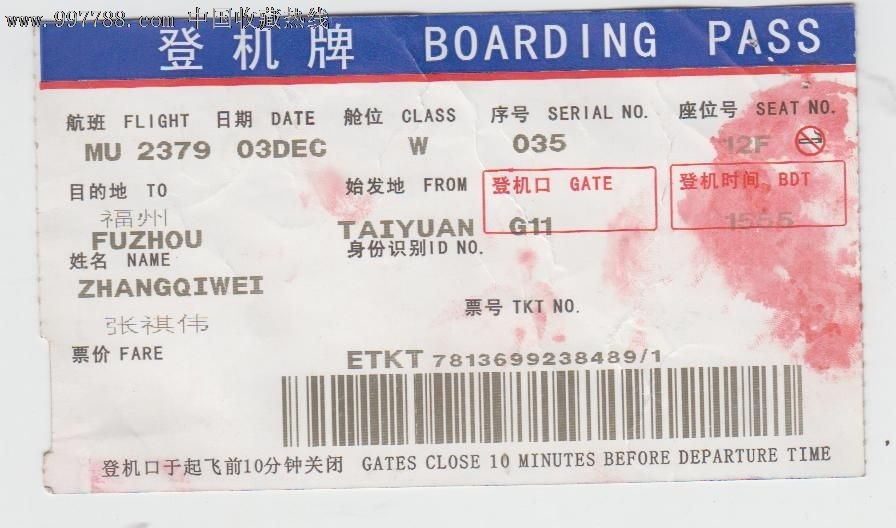

In [3]:
String url = "https://resources.djl.ai/images/flight_ticket.jpg";
Image img = ImageFactory.getInstance().fromUrl(url);
img.getWrappedImage();

## 文字區塊檢測
我們首先從 [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.0/doc/doc_en/inference_en.md#convert-detection-model-to-inference-model) 開發套件中讀取文字檢測的模型，之後我們可以生成一個DJL `Predictor` 並將其命名為 `detector`.


In [4]:
var criteria1 = Criteria.builder()
        .optEngine("PaddlePaddle")
        .setTypes(Image.class, DetectedObjects.class)
        .optModelUrls("https://resources.djl.ai/test-models/paddleOCR/mobile/det_db.zip")
        .optTranslator(new PpWordDetectionTranslator(new ConcurrentHashMap<String, String>()))
        .build();
var detectionModel = criteria1.loadModel();
var detector = detectionModel.newPredictor();

[IJava-executor-0] INFO ai.djl.pytorch.engine.PtEngine - PyTorch graph executor optimizer is enabled, this may impact your inference latency and throughput. See: https://docs.djl.ai/docs/development/inference_performance_optimization.html#graph-executor-optimization
[IJava-executor-0] INFO ai.djl.pytorch.engine.PtEngine - Number of inter-op threads is 6
[IJava-executor-0] INFO ai.djl.pytorch.engine.PtEngine - Number of intra-op threads is 6


接著我們檢測出圖片中的文字區塊，這個模型的原始輸出是含有標註所有文字區域的圖算法(Bitmap)，我們可以利用`PpWordDetectionTranslator` 函式將圖算法的輸出轉成長方形的方框來裁剪圖片

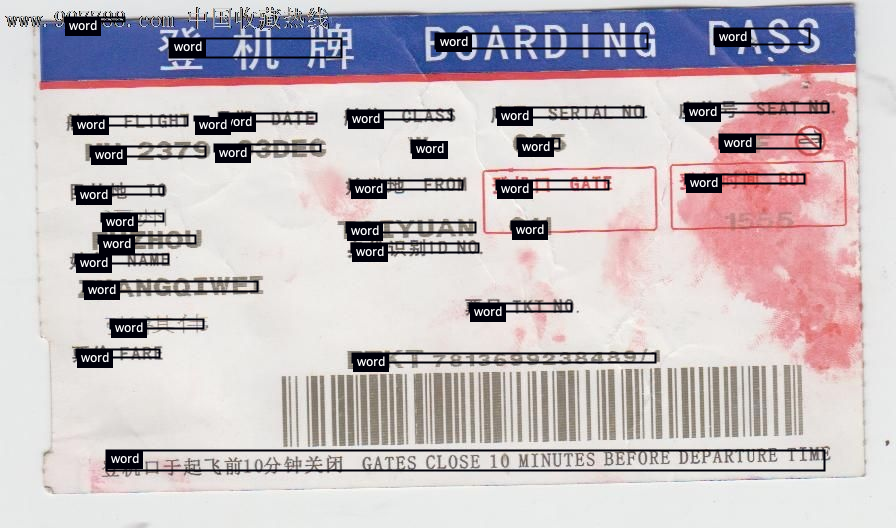

In [5]:
var detectedObj = detector.predict(img);
Image newImage = img.duplicate();
newImage.drawBoundingBoxes(detectedObj);
newImage.getWrappedImage();

如上所示，所標註的文字區塊都非常窄，且沒有包住所有完整的文字區塊。讓我們嘗試使用`extendRect`函式來擴展文字框的長寬到需要的大小, 再利用 `getSubImage` 裁剪並擷取出文子區塊。

In [6]:
Image getSubImage(Image img, BoundingBox box) {
    Rectangle rect = box.getBounds();
    double[] extended = extendRect(rect.getX(), rect.getY(), rect.getWidth(), rect.getHeight());
    int width = img.getWidth();
    int height = img.getHeight();
    int[] recovered = {
        (int) (extended[0] * width),
        (int) (extended[1] * height),
        (int) (extended[2] * width),
        (int) (extended[3] * height)
    };
    return img.getSubImage(recovered[0], recovered[1], recovered[2], recovered[3]);
}

double[] extendRect(double xmin, double ymin, double width, double height) {
    double centerx = xmin + width / 2;
    double centery = ymin + height / 2;
    if (width > height) {
        width += height * 2.0;
        height *= 3.0;
    } else {
        height += width * 2.0;
        width *= 3.0;
    }
    double newX = centerx - width / 2 < 0 ? 0 : centerx - width / 2;
    double newY = centery - height / 2 < 0 ? 0 : centery - height / 2;
    double newWidth = newX + width > 1 ? 1 - newX : width;
    double newHeight = newY + height > 1 ? 1 - newY : height;
    return new double[] {newX, newY, newWidth, newHeight};
}

讓我們輸出其中一個文字區塊

In [7]:
List<DetectedObjects.DetectedObject> boxes = detectedObj.items();
var sample = getSubImage(img, boxes.get(5).getBoundingBox());
sample.getWrappedImage();

## 文字角度檢測
我們從 [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.0/doc/doc_en/inference_en.md#convert-angle-classification-model-to-inference-model) 輸出這個模型並確認圖片及文字是否需要旋轉。以下的代碼會讀入這個模型並生成a `rotateClassifier` 子類別

In [8]:
var criteria2 = Criteria.builder()
        .optEngine("PaddlePaddle")
        .setTypes(Image.class, Classifications.class)
        .optModelUrls("https://resources.djl.ai/test-models/paddleOCR/mobile/cls.zip")
        .optTranslator(new PpWordRotateTranslator())
        .build();
var rotateModel = criteria2.loadModel();
var rotateClassifier = rotateModel.newPredictor();

## 文字識別

我們從 [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.0/doc/doc_en/inference_en.md#convert-recognition-model-to-inference-model) 輸出這個模型並識別圖片中的文字, 我們一樣仿造上述的步驟讀取這個模型


In [9]:
var criteria3 = Criteria.builder()
        .optEngine("PaddlePaddle")
        .setTypes(Image.class, String.class)
        .optModelUrls("https://resources.djl.ai/test-models/paddleOCR/mobile/rec_crnn.zip")
        .optTranslator(new PpWordRecognitionTranslator())
        .build();
var recognitionModel = criteria3.loadModel();
var recognizer = recognitionModel.newPredictor();

接著我們可以試著套用這兩個模型在先前剪裁好的文字區塊上

In [10]:
System.out.println(rotateClassifier.predict(sample));
recognizer.predict(sample);

[
	{"class": "Rotate", "probability": 0.52805}
	{"class": "No Rotate", "probability": 0.47194}
]


序号SERIALNO.

最後我們把這些模型串連在一起並套用在整張圖片上看看結果會如何。DJL提供了豐富的影像工具包讓你可以從圖片中擷取出文字並且完美呈現

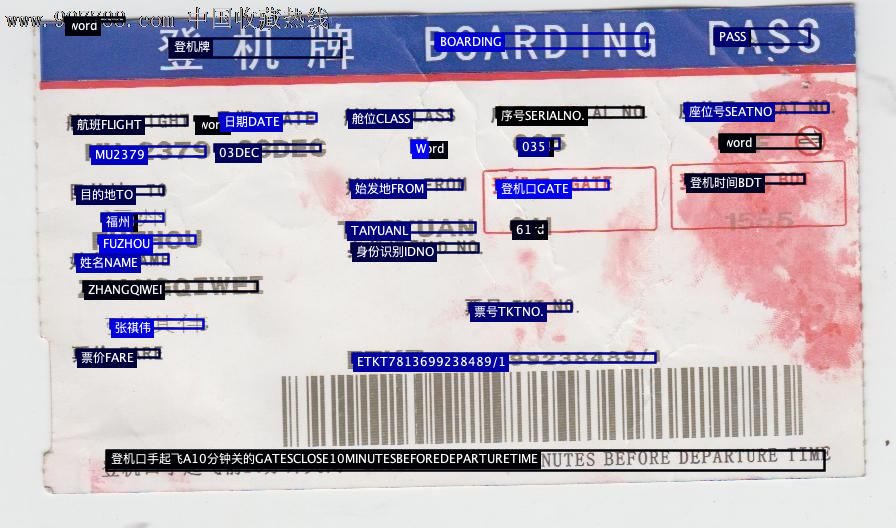

In [11]:
Image rotateImg(Image image) {
    try (NDManager manager = NDManager.newBaseManager()) {
        NDArray rotated = NDImageUtils.rotate90(image.toNDArray(manager), 1);
        return ImageFactory.getInstance().fromNDArray(rotated);
    }
}

List<String> names = new ArrayList<>();
List<Double> prob = new ArrayList<>();
List<BoundingBox> rect = new ArrayList<>();

for (int i = 0; i < boxes.size(); i++) {
    Image subImg = getSubImage(img, boxes.get(i).getBoundingBox());
    if (subImg.getHeight() * 1.0 / subImg.getWidth() > 1.5) {
        subImg = rotateImg(subImg);
    }
    Classifications.Classification result = rotateClassifier.predict(subImg).best();
    if ("Rotate".equals(result.getClassName()) && result.getProbability() > 0.8) {
        subImg = rotateImg(subImg);
    }
    String name = recognizer.predict(subImg);
    names.add(name);
    prob.add(-1.0);
    rect.add(boxes.get(i).getBoundingBox());
}
newImage.drawBoundingBoxes(new DetectedObjects(names, prob, rect));
newImage.getWrappedImage();